# Finetune DETR, a model that combines a convolutional backbone with an encoder-decoder Transformer, on the CPPE-5 dataset.



## Setup

In [1]:
!pip install -q datasets transformers accelerate timm
!pip install -q -U albumentations>=1.4.5 torchmetrics pycocotools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [2]:
import torch

torch.cuda.is_available()

True

In [3]:
!nvidia-smi

Tue Sep 10 06:48:32 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
# Login to huggingface hub
from huggingface_hub import notebook_login

notebook_login()

In [5]:
# Define global constants
MODEL_NAME = "facebook/detr-resnet-50" #"microsoft/conditional-detr-resnet-50"
IMAGE_SIZE = 480

## Load the CPPE-5 dataset

The CPPE-5 dataset contains images with annotations identifying medical personal protective equipment (PPE) in the context of the COVID-19 pandemic.

In [6]:
from datasets import load_dataset

cppe5 = load_dataset("cppe-5")

if "validation" not in cppe5:
    split = cppe5["train"].train_test_split(0.15, seed=42)
    cppe5["train"] = split["train"]
    cppe5["validation"] = split["test"]

cppe5

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/29 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 850
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 29
    })
    validation: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 150
    })
})

In [7]:
# Explore an example
cppe5["train"][0]

{'image_id': 9,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=200x200>,
 'width': 200,
 'height': 200,
 'objects': {'id': [56, 57, 58],
  'area': [2160, 306, 13593],
  'bbox': [[146.0, 86.0, 54.0, 40.0],
   [33.0, 22.0, 18.0, 17.0],
   [2.0, 3.0, 69.0, 197.0]],
  'category': [4, 4, 0]}}

The examples in the dataset have the following fields:
- `image_id`: the example image id
- `image`: a `PIL.Image.Image` object containing the image
- `width`: width of the image
- `height`: height of the image
- `objects`: a dictionary containing bounding box metadata for the objects in the image:
  - `id`: the annotation id
  - `area`: the area of the bounding box
  - `bbox`: the object's bounding box (in the [COCO format](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/#coco) )
  - `category`: the object's category, with possible values including `Coverall (0)`, `Face_Shield (1)`, `Gloves (2)`, `Goggles (3)` and `Mask (4)`



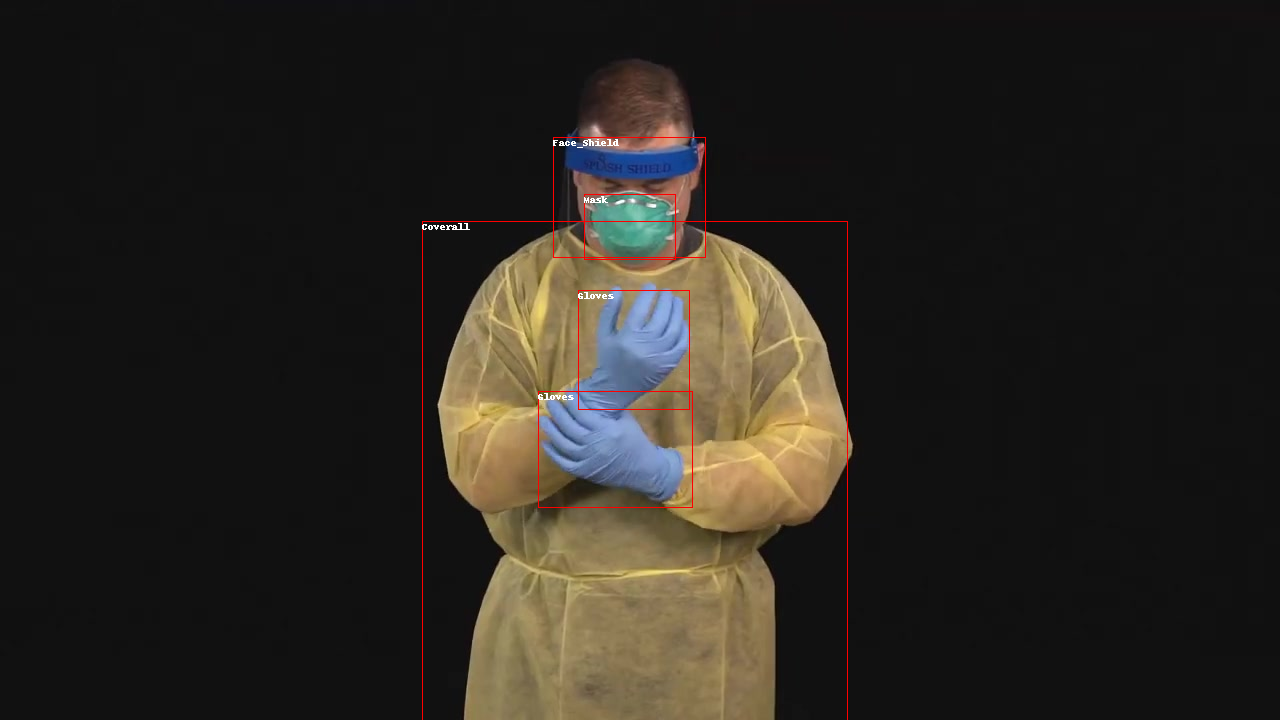

In [8]:
# Visualize an example in the dataset
import numpy as np
import os
from PIL import Image, ImageDraw

image = cppe5["train"][2]["image"]
annotations = cppe5["train"][2]["objects"]
draw = ImageDraw.Draw(image)

categories = cppe5["train"].features["objects"].feature["category"].names

id2label = {index: x for index, x in enumerate(categories, start=0)}
label2id = {v: k for k, v in id2label.items()}

for i in range(len(annotations["id"])):
    box = annotations["bbox"][i]
    class_idx = annotations["category"][i]
    x, y, w, h = tuple(box)
    # Check if coordinates are normalized or not
    if max(box) > 1.0:
        # Coordinates are un-normalized, no need to re-scale them
        x1, y1 = int(x), int(y)
        x2, y2 = int(x + w), int(y + h)
    else:
        # Coordinates are normalized, re-scale them
        x1 = int(x * width)
        y1 = int(y * height)
        x2 = int((x + w) * width)
        y2 = int((y + h) * height)
    draw.rectangle((x, y, x + w, y + h), outline="red", width=1)
    draw.text((x, y), id2label[class_idx], fill="white")

image

## Preprocess the data

In [9]:
# Instantiate the image processor from the checkpoint
from transformers import AutoImageProcessor

MAX_SIZE = IMAGE_SIZE

image_processor = AutoImageProcessor.from_pretrained(
    MODEL_NAME,
    do_resize=True,
    size={"max_height": MAX_SIZE, "max_width": MAX_SIZE},
    do_pad=True,
    pad_size={"height": MAX_SIZE, "width": MAX_SIZE},
)

preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

In [10]:
# Annotate and Reformat images to meet DETR expectations
import albumentations as A

train_augment_and_transform = A.Compose(
    [
        A.Perspective(p=0.1),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.1),
    ],
    bbox_params=A.BboxParams(format="coco", label_fields=["category"], clip=True, min_area=25),
)

validation_transform = A.Compose(
    [A.NoOp()],
    bbox_params=A.BboxParams(format="coco", label_fields=["category"], clip=True),
)

In [11]:
# Define a function to reformat annotation
def format_image_annotations_as_coco(image_id, categories, areas, bboxes):
    """Format one set of image annotations to the COCO format

    Args:
        image_id (str): image id. e.g. "0001"
        categories (List[int]): list of categories/class labels corresponding to provided bounding boxes
        areas (List[float]): list of corresponding areas to provided bounding boxes
        bboxes (List[Tuple[float]]): list of bounding boxes provided in COCO format
            ([center_x, center_y, width, height] in absolute coordinates)

    Returns:
        dict: {
            "image_id": image id,
            "annotations": list of formatted annotations
        }
    """
    annotations = []
    for category, area, bbox in zip(categories, areas, bboxes):
        formatted_annotation = {
            "image_id": image_id,
            "category_id": category,
            "iscrowd": 0,
            "area": area,
            "bbox": list(bbox),
        }
        annotations.append(formatted_annotation)

    return {
        "image_id": image_id,
        "annotations": annotations,
    }

In [12]:
# Combine the image and annotation transformations
def augment_and_transform_batch(examples, transform, image_processor, return_pixel_mask=False):
    """Apply augmentations and format annotations in COCO format for object detection task"""

    images = []
    annotations = []
    for image_id, image, objects in zip(examples["image_id"], examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))

        # apply augmentations
        output = transform(image=image, bboxes=objects["bbox"], category=objects["category"])
        images.append(output["image"])

        # format annotations in COCO format
        formatted_annotations = format_image_annotations_as_coco(
            image_id, output["category"], objects["area"], output["bboxes"]
        )
        annotations.append(formatted_annotations)

    # Apply the image processor transformations: resizing, rescaling, normalization
    result = image_processor(images=images, annotations=annotations, return_tensors="pt")

    if not return_pixel_mask:
        result.pop("pixel_mask", None)

    return result

In [13]:
# Apply preprocessing function to entire dataset
from functools import partial

# Make transform functions for batch and apply for dataset splits
train_transform_batch = partial(
    augment_and_transform_batch, transform=train_augment_and_transform, image_processor=image_processor
)
validation_transform_batch = partial(
    augment_and_transform_batch, transform=validation_transform, image_processor=image_processor
)

cppe5["train"] = cppe5["train"].with_transform(train_transform_batch)
cppe5["validation"] = cppe5["validation"].with_transform(validation_transform_batch)
cppe5["test"] = cppe5["test"].with_transform(validation_transform_batch)

cppe5["train"][15]

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


{'pixel_values': tensor([[[ 1.1700,  1.1700,  1.1700,  ..., -1.9467, -1.9467, -1.9467],
          [ 1.1700,  1.1700,  1.1700,  ..., -1.9467, -1.9467, -1.9467],
          [ 1.1700,  1.1700,  1.1700,  ..., -1.9295, -1.9295, -1.9295],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
 
         [[ 1.5357,  1.5357,  1.5357,  ..., -0.9678, -0.9678, -0.9678],
          [ 1.5357,  1.5357,  1.5357,  ..., -0.9678, -0.9678, -0.9678],
          [ 1.5357,  1.5357,  1.5357,  ..., -0.9503, -0.9503, -0.9503],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
 
         [[ 1.1934,  1.1934,  1.1934,  ..., -0.4101, -0.4101, -0.4101],
          [ 

In [14]:
# Create a custom collate function to batch images together
import torch

def collate_fn(batch):
    data = {}
    data["pixel_values"] = torch.stack([x["pixel_values"] for x in batch])
    data["labels"] = [x["labels"] for x in batch]
    if "pixel_mask" in batch[0]:
        data["pixel_mask"] = torch.stack([x["pixel_mask"] for x in batch])
    return data


## Preparing evaluation function to compute mAP

We are going to use torchmetrics to compute `mAP (mean average precision)` and `mAR (mean average recall)` metrics

In [15]:
from transformers.image_transforms import center_to_corners_format

def convert_bbox_yolo_to_pascal(boxes, image_size):
    """
    Convert bounding boxes from YOLO format (x_center, y_center, width, height) in range [0, 1]
    to Pascal VOC format (x_min, y_min, x_max, y_max) in absolute coordinates.

    Args:
        boxes (torch.Tensor): Bounding boxes in YOLO format
        image_size (Tuple[int, int]): Image size in format (height, width)

    Returns:
        torch.Tensor: Bounding boxes in Pascal VOC format (x_min, y_min, x_max, y_max)
    """
    # convert center to corners format
    boxes = center_to_corners_format(boxes)

    # convert to absolute coordinates
    height, width = image_size
    boxes = boxes * torch.tensor([[width, height, width, height]])

    return boxes

 In compute_metrics function we collect predicted and target bounding boxes, scores and labels from evaluation loop results and pass it to the scoring function.

In [16]:
import numpy as np
from dataclasses import dataclass
from torchmetrics.detection.mean_ap import MeanAveragePrecision


@dataclass
class ModelOutput:
    logits: torch.Tensor
    pred_boxes: torch.Tensor


@torch.no_grad()
def compute_metrics(evaluation_results, image_processor, threshold=0.0, id2label=None):
    """
    Compute mean average mAP, mAR and their variants for the object detection task.

    Args:
        evaluation_results (EvalPrediction): Predictions and targets from evaluation.
        threshold (float, optional): Threshold to filter predicted boxes by confidence. Defaults to 0.0.
        id2label (Optional[dict], optional): Mapping from class id to class name. Defaults to None.

    Returns:
        Mapping[str, float]: Metrics in a form of dictionary {<metric_name>: <metric_value>}
    """

    predictions, targets = evaluation_results.predictions, evaluation_results.label_ids

    # For metric computation we need to provide:
    #  - targets in a form of list of dictionaries with keys "boxes", "labels"
    #  - predictions in a form of list of dictionaries with keys "boxes", "scores", "labels"

    image_sizes = []
    post_processed_targets = []
    post_processed_predictions = []

    # Collect targets in the required format for metric computation
    for batch in targets:
        # collect image sizes, we will need them for predictions post processing
        batch_image_sizes = torch.tensor(np.array([x["orig_size"] for x in batch]))
        image_sizes.append(batch_image_sizes)
        # collect targets in the required format for metric computation
        # boxes were converted to YOLO format needed for model training
        # here we will convert them to Pascal VOC format (x_min, y_min, x_max, y_max)
        for image_target in batch:
            boxes = torch.tensor(image_target["boxes"])
            boxes = convert_bbox_yolo_to_pascal(boxes, image_target["orig_size"])
            labels = torch.tensor(image_target["class_labels"])
            post_processed_targets.append({"boxes": boxes, "labels": labels})

    # Collect predictions in the required format for metric computation,
    # model produce boxes in YOLO format, then image_processor convert them to Pascal VOC format
    for batch, target_sizes in zip(predictions, image_sizes):
        batch_logits, batch_boxes = batch[1], batch[2]
        output = ModelOutput(logits=torch.tensor(batch_logits), pred_boxes=torch.tensor(batch_boxes))
        post_processed_output = image_processor.post_process_object_detection(
            output, threshold=threshold, target_sizes=target_sizes
        )
        post_processed_predictions.extend(post_processed_output)

    # Compute metrics
    metric = MeanAveragePrecision(box_format="xyxy", class_metrics=True)
    metric.update(post_processed_predictions, post_processed_targets)
    metrics = metric.compute()

    # Replace list of per class metrics with separate metric for each class
    classes = metrics.pop("classes")
    map_per_class = metrics.pop("map_per_class")
    mar_100_per_class = metrics.pop("mar_100_per_class")
    for class_id, class_map, class_mar in zip(classes, map_per_class, mar_100_per_class):
        class_name = id2label[class_id.item()] if id2label is not None else class_id.item()
        metrics[f"map_{class_name}"] = class_map
        metrics[f"mar_100_{class_name}"] = class_mar

    metrics = {k: round(v.item(), 4) for k, v in metrics.items()}

    return metrics


eval_compute_metrics_fn = partial(
    compute_metrics, image_processor=image_processor, id2label=id2label, threshold=0.0
)

## Train the model

In [17]:
# Load the model with AutoModelForObjectDetection using the same checkpoint as in the preprocessing.
from transformers import AutoModelForObjectDetection

model = AutoModelForObjectDetection.from_pretrained(
    MODEL_NAME,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

config.json:   0%|          | 0.00/4.59k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

In [18]:
# Define the training hyperparameters
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="detr_finetuned_cppe5",
    num_train_epochs=30,
    fp16=False,
    per_device_train_batch_size=8,
    dataloader_num_workers=4,
    learning_rate=5e-5,
    lr_scheduler_type="cosine",
    weight_decay=1e-4,
    max_grad_norm=0.01,
    metric_for_best_model="eval_map",
    greater_is_better=True,
    load_best_model_at_end=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    remove_unused_columns=False,
    eval_do_concat_batches=False,
    push_to_hub=True,
)

In [19]:
# Define the trainer function
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=cppe5["train"],
    eval_dataset=cppe5["validation"],
    tokenizer=image_processor,
    data_collator=collate_fn,
    compute_metrics=eval_compute_metrics_fn,
)

In [20]:
# Train the model
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch,Training Loss,Validation Loss,Map,Map 50,Map 75,Map Small,Map Medium,Map Large,Mar 1,Mar 10,Mar 100,Mar Small,Mar Medium,Mar Large,Map Coverall,Mar 100 Coverall,Map Face Shield,Mar 100 Face Shield,Map Gloves,Mar 100 Gloves,Map Goggles,Mar 100 Goggles,Map Mask,Mar 100 Mask
1,No log,2.107344,0.051800,0.107500,0.042300,0.004000,0.050000,0.053000,0.095100,0.183600,0.219200,0.106600,0.187200,0.207900,0.245400,0.690000,0.000000,0.000000,0.004600,0.173600,0.000000,0.000000,0.008900,0.232300
2,No log,1.991213,0.068600,0.135900,0.061800,0.005400,0.078700,0.071300,0.107700,0.196600,0.236200,0.096500,0.187400,0.263600,0.295300,0.707800,0.000000,0.000000,0.009200,0.191000,0.000000,0.000000,0.038600,0.282000
3,No log,1.871224,0.067400,0.133900,0.059300,0.008800,0.066600,0.069400,0.098400,0.188500,0.235100,0.105600,0.188500,0.237800,0.304000,0.701100,0.000000,0.000000,0.009600,0.204500,0.000000,0.000000,0.023700,0.269800
4,No log,1.781239,0.101200,0.184400,0.095000,0.008400,0.098900,0.104600,0.118300,0.210400,0.253900,0.129100,0.214000,0.258400,0.438400,0.703900,0.002000,0.001600,0.015400,0.228100,0.000000,0.000000,0.050100,0.336000
5,2.140200,1.622036,0.122300,0.225800,0.111500,0.016800,0.107800,0.126200,0.122500,0.238700,0.270000,0.145700,0.224800,0.288200,0.504900,0.722200,0.001000,0.001600,0.033700,0.269700,0.000000,0.000000,0.072000,0.356600
6,2.140200,1.597809,0.125700,0.247500,0.113000,0.029700,0.097500,0.134700,0.133600,0.248800,0.270300,0.160400,0.220300,0.303700,0.505000,0.715600,0.002000,0.003200,0.037400,0.263500,0.000000,0.000000,0.084200,0.369300
7,2.140200,1.589791,0.142800,0.273000,0.126600,0.027500,0.128700,0.163900,0.176900,0.280200,0.307000,0.177500,0.257300,0.342800,0.530700,0.703300,0.033600,0.141900,0.046200,0.313500,0.005300,0.016700,0.098400,0.359800
8,2.140200,1.498658,0.150900,0.311600,0.127700,0.049900,0.142500,0.167100,0.192100,0.312800,0.340400,0.204100,0.308900,0.377900,0.525500,0.734400,0.057400,0.253200,0.045800,0.316900,0.003700,0.029200,0.122000,0.368300
9,2.140200,1.522783,0.141900,0.295400,0.118100,0.043400,0.145700,0.173500,0.173900,0.296900,0.319400,0.183100,0.277300,0.398100,0.492800,0.703300,0.036900,0.146800,0.036500,0.255600,0.014600,0.120800,0.128700,0.370400
10,1.666300,1.503330,0.155000,0.326500,0.132500,0.094500,0.155200,0.175700,0.206300,0.341600,0.365500,0.207800,0.335800,0.428800,0.503200,0.722800,0.056000,0.251600,0.055100,0.328100,0.025500,0.147900,0.135300,0.377200


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/utils/data/data

TrainOutput(global_step=3210, training_loss=1.4714351000444168, metrics={'train_runtime': 2502.693, 'train_samples_per_second': 10.189, 'train_steps_per_second': 1.283, 'total_flos': 4.3863490469376e+18, 'train_loss': 1.4714351000444168, 'epoch': 30.0})

In [21]:
# Push the model to the Hub
trainer.push_to_hub()

CommitInfo(commit_url='https://huggingface.co/ashaduzzaman/detr_finetuned_cppe5/commit/421099e37d6d9ea7bb2150f45245b33ac9a44c18', commit_message='End of training', commit_description='', oid='421099e37d6d9ea7bb2150f45245b33ac9a44c18', pr_url=None, pr_revision=None, pr_num=None)

## Evaluate the Model

In [23]:
from pprint import pprint
metrics = trainer.evaluate(eval_dataset=cppe5["test"], metric_key_prefix="test")
pprint(metrics)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


{'epoch': 30.0,
 'test_loss': 1.1822617053985596,
 'test_map': 0.2718,
 'test_map_50': 0.5666,
 'test_map_75': 0.2085,
 'test_map_Coverall': 0.4219,
 'test_map_Face_Shield': 0.2707,
 'test_map_Gloves': 0.261,
 'test_map_Goggles': 0.1024,
 'test_map_Mask': 0.3031,
 'test_map_large': 0.4154,
 'test_map_medium': 0.1939,
 'test_map_small': 0.1549,
 'test_mar_1': 0.2653,
 'test_mar_10': 0.5019,
 'test_mar_100': 0.518,
 'test_mar_100_Coverall': 0.7205,
 'test_mar_100_Face_Shield': 0.5588,
 'test_mar_100_Gloves': 0.4475,
 'test_mar_100_Goggles': 0.4379,
 'test_mar_100_Mask': 0.4255,
 'test_mar_large': 0.6701,
 'test_mar_medium': 0.3909,
 'test_mar_small': 0.2681,
 'test_runtime': 5.0584,
 'test_samples_per_second': 5.733,
 'test_steps_per_second': 0.791}


## Model Inference

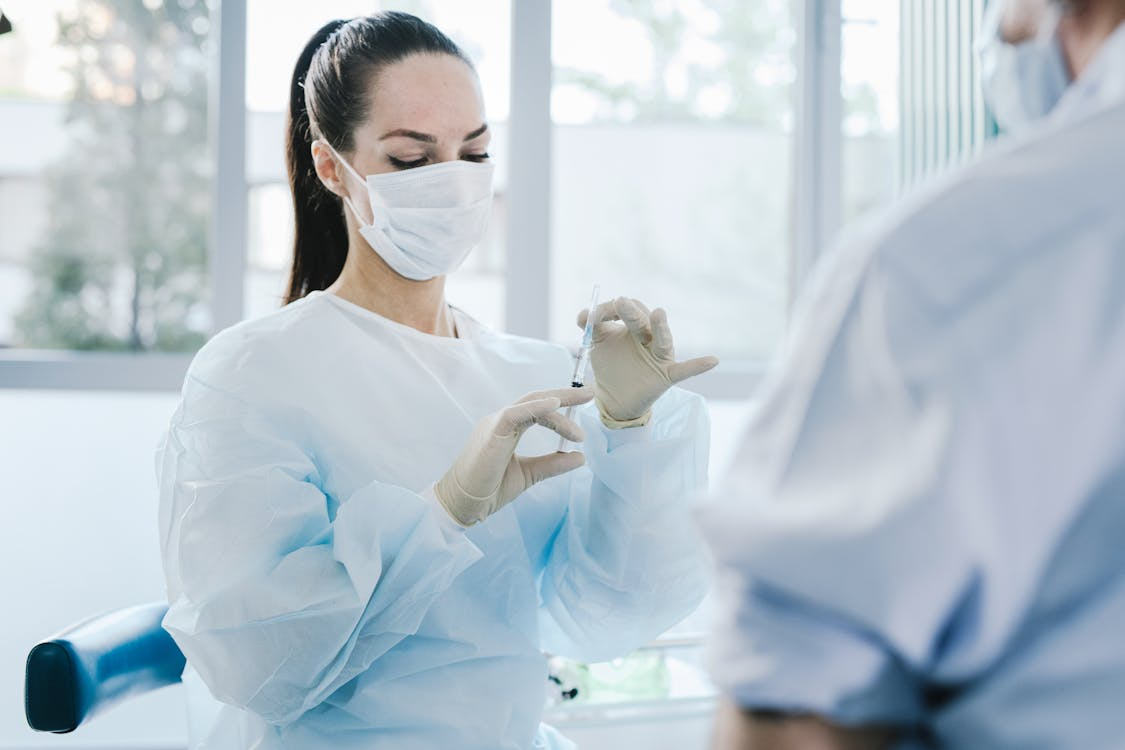

In [24]:
import torch
import requests

from PIL import Image, ImageDraw
from transformers import AutoImageProcessor, AutoModelForObjectDetection

url="https://images.pexels.com/photos/8413299/pexels-photo-8413299.jpeg?auto=compress&cs=tinysrgb&w=630&h=375&dpr=2"

image = Image.open(requests.get(url, stream=True).raw)
image

In [25]:
# Load model and image processor from huggingface hub
device = "cuda"
model_repo = "ashaduzzaman/detr_finetuned_cppe5"

image_processor = AutoImageProcessor.from_pretrained(model_repo)
model = AutoModelForObjectDetection.from_pretrained(model_repo)
model = model.to(device)

preprocessor_config.json:   0%|          | 0.00/485 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/166M [00:00<?, ?B/s]

In [26]:
# Detect the bounding boxes
with torch.no_grad():
    inputs = image_processor(images=image, return_tensors="pt")
    outputs = model(**inputs.to(device))
    target_sizes = torch.tensor([[image.size[1], image.size[0]]])
    results = image_processor.post_process_object_detection(outputs, threshold=0.3, target_sizes=target_sizes)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence"
        f"{round(score.item(), 3)} at location {box}"
    )

Detected Gloves with confidence0.395 at location [13.52, 608.96, 198.08, 743.87]
Detected Face_Shield with confidence0.406 at location [317.68, 162.66, 515.31, 294.36]
Detected Mask with confidence0.452 at location [976.35, 61.78, 1062.44, 130.34]
Detected Mask with confidence0.857 at location [339.3, 174.38, 501.73, 284.99]
Detected Gloves with confidence0.91 at location [564.15, 315.86, 709.05, 432.6]
Detected Coverall with confidence0.73 at location [146.32, 26.67, 739.13, 745.97]
Detected Gloves with confidence0.74 at location [572.57, 342.02, 668.5, 431.46]
Detected Gloves with confidence0.905 at location [420.94, 397.5, 598.95, 523.55]
Detected Coverall with confidence0.898 at location [669.0, 4.24, 1120.54, 744.43]


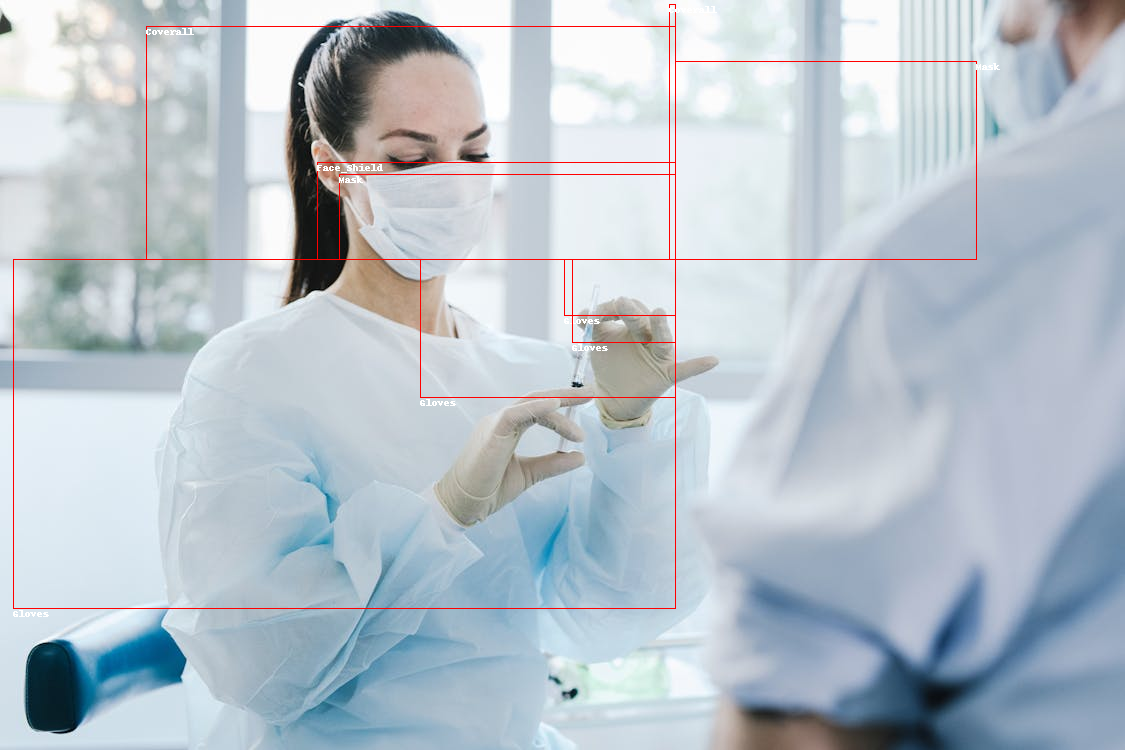

In [27]:
# Let’s visualize the result
draw = ImageDraw.Draw(image)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    x, y, w, h = tuple(box)
    draw.rectangle((x, y, x2, y2), outline="red", width=1)
    draw.text((x, y), model.config.id2label[label.item()], fill="white")

image